In [1]:
#import sys
#!{sys.executable} -m pip install

import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
df = pd.read_csv("data/voteHistory.csv")
df = df[df['chamber']=='House'].copy()
members = pd.read_csv("data/memberDescription.csv")

## District Clustering

#### Loading data from raw state CSVs

In [16]:
def DistrictCuration(DisData, DisDataB):
    districts = pd.DataFrame()
    
    if DisData.columns[3] == ' (At Large) ':
        DisData = DisData.rename(columns={' (At Large) ':'01'})
        DisDataB = DisDataB.rename(columns={' (At Large) ':'01'})
    
    #print(DisData.iloc[98].iloc[3:].astype(float))
    #print(DisData.iloc[DisData[DisData['Titl']=='Car, truck, or van -- drove alone'].index[0]].iloc[3:].astype(float))
    
    age = DisData.iloc[DisData[DisData['Titl']=='Median age (years)'].index[0]].iloc[3:].astype(float)
    pop = DisData.iloc[DisData[((DisData['Titl'] == 'Total population') & (DisData['Subjec'] == 'Race'))].index[0]].T.iloc[3:].astype(float)
    minority = DisData.iloc[DisData[DisData['Titl']=='White'].index[0]].T.iloc[3:].astype(float)
    vet = DisData.iloc[DisData[DisData['Titl']=='Civilian veterans'].index[0]].T.iloc[3:].astype(float)
    #dis = DisData.iloc[77].iloc[3:].astype(float)
    emp = DisData.iloc[DisData[DisData['Titl']=='Unemployment Rate'].index[0]].iloc[3:].astype(float)
    cmt = DisData.iloc[DisData[DisData['Titl']=='Car, truck, or van -- drove alone'].index[0]].iloc[3:].astype(float)
    ttlCmt = DisData.iloc[DisData[DisData['Titl']=='Workers 16 years and over'].index[0]].iloc[3:].astype(float)
    indAgg = DisData.iloc[DisData[DisData['Titl']=='Agriculture, forestry, fishing and hunting, and mining'].index[0]].iloc[3:].astype(float)
    indCon = DisData.iloc[DisData[DisData['Titl']=='Construction'].index[0]].iloc[3:].astype(float)
    indMan = DisData.iloc[DisData[DisData['Titl']=='Manufacturing'].index[0]].iloc[3:].astype(float)
    indWho = DisData.iloc[DisData[DisData['Titl']=='Wholesale trade'].index[0]].iloc[3:].astype(float)
    indTra = DisData.iloc[DisData[DisData['Titl']=='Transportation and warehousing, and utilities'].index[0]].iloc[3:].astype(float)
    indOth = DisData.iloc[DisData[DisData['Titl']=='Other services, except public administration'].index[0]].iloc[3:].astype(float)
    indB = indAgg+indCon+indMan+indWho+indTra+indOth
    ownO = DisData.iloc[DisData[DisData['Titl']=='Owner-occupied'].index[0]].iloc[3:].astype(float) 
    totH = DisData.iloc[DisData[DisData['Titl']=='Total housing units'].index[0]].iloc[3:].astype(float)
    inc = DisData.iloc[DisData[DisData['Titl']=='Median household income (dollars)'].index[0]].iloc[3:].astype(float)
    pov = DisData.iloc[DisData[DisData['Titl']=='All people'].index[0]].iloc[3:].astype(float)
    bac = DisData.iloc[DisData[DisData['Titl']=="Percent bachelor's degree or higher"].index[0]].iloc[3:].astype(float)

    districts['Age'] = age
    districts['Pop'] = pop
    districts['PerMin'] = minority
    districts['PerMin'] = 1-districts['PerMin']/districts['Pop']
    districts['PerVet'] = vet/districts['Pop']
    #districts['PerDis'] = dis/districts['Pop']
    districts['UnEmp'] = emp/100
    districts['CarCommute'] = cmt/ttlCmt
    districts['PerBlu'] = indB/ttlCmt
    districts['PerOwnOcc'] = ownO/totH
    districts['MedIncome'] = inc
    districts['BelowPovLine'] = pov/100
    districts['PerBachelors'] = bac/100
    
    payroll = DisDataB.iloc[21].iloc[3:].astype(float)
    TopEmplr = []
    for i in DisDataB.iloc[:,3:]:
        TopEmplr.append(DisDataB.iloc[DisDataB.iloc[1:19,int(i)+2].idxmax(),2])
    
    districts['Payroll'] = payroll
    districts['TopEmplr'] = TopEmplr
    
    return districts

In [17]:
import os
from sklearn.preprocessing import StandardScaler

directory = "Data\DistrictData"

DistrictData = pd.DataFrame()

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        if filename[0:2] not in ['NC']:
            DisData = pd.read_csv(f,skiprows=0, nrows=241)
            dropcol = [col for col in DisData.columns if 'MOE' in col]
            DisData = DisData.drop(dropcol,axis=1)
            DisData.columns = [col.lstrip("District").rstrip("Estimate") for col in DisData.columns]
            
            DisDataB = pd.read_csv(f,skiprows=256,nrows=64)
            dropcolB = [col for col in DisDataB.columns if 'Flag' in col]
            DisDataB = DisDataB.drop(dropcolB,axis=1)
            DisDataB.columns = [col.lstrip("District").rstrip("Estimate") for col in DisDataB.columns]
            
            #if filename[0:2] == 'NY':
            curatedData = DistrictCuration(DisData,DisDataB)
            curatedData['state_abbrev'] = filename[0:2]
            frames = [DistrictData,curatedData]
            
            DistrictData = pd.concat(frames)

DistrictData['district_code'] = DistrictData.index
DistrictData['district_code'] = DistrictData['district_code'].astype(int)
DistrictData = DistrictData.reset_index()

#Scale our Quant variables
scaler = StandardScaler()
DDScl = pd.DataFrame(scaler.fit_transform(DistrictData[['Age','Pop','PerMin','PerVet','UnEmp','CarCommute','PerBlu','PerOwnOcc','MedIncome','BelowPovLine','PerBachelors','Payroll']]))
DDScl.columns = ['Age','Pop','PerMin','PerVet','UnEmp','CarCommute','PerBlu','PerOwnOcc','MedIncome','BelowPovLine','PerBachelors','Payroll']

#DDScl = DDScl[['Age','PerMin','PerVet','UnEmp','CarCommute','PerBlu','PerOwnOcc','MedIncome','BelowPovLine']]

DDScl[['TopEmplr','state_abbrev','district_code']] = DistrictData[['TopEmplr','state_abbrev','district_code']]
DistrictData = DDScl.copy()

#OneHotEncode Top Employer
tpEmp = pd.get_dummies(DistrictData.TopEmplr)
DistrictData = pd.concat([DistrictData,tpEmp],axis=1)

DistrictData = DistrictData.set_index(['state_abbrev','district_code'])
DistrictData = DistrictData.drop(columns=["TopEmplr"])
DistrictData.head(5)

Age       Pop    PerMin    PerVet     UnEmp  \
state_abbrev district_code                                                     
AK           1             -1.036816 -0.191980  0.464799  1.323145  0.820845   
AL           1              0.442061 -0.298601  0.308520  1.090153  0.751790   
             2              0.058649 -0.619950  0.545030  1.217764 -0.076873   
             3              0.031262 -0.295139  0.193313  0.628579  0.889900   
             4              0.633767 -0.525226 -0.852127  0.150218 -0.214983   

                            CarCommute    PerBlu  PerOwnOcc  MedIncome  \
state_abbrev district_code                                               
AK           1               -0.518045 -0.165905  -0.533351   0.360685   
AL           1                0.773726  0.368140  -0.289675  -0.939503   
             2                0.844389  0.284748  -0.221290  -0.948363   
             3                0.642409  0.895746   0.284040  -0.873340   
             4                0.819121  2.038371   0.440260  -1.103704   

                            BelowPovLine  ...  Educational services  \
state_abbrev district_code                ...                         
AK           1                 -0.489555  ...                     0   
AL           1                  0.617214  ...                     0   
             2                  0.826039  ...                     0   
             3                  0.533684  ...                     0   
             4                  0.658979  ...                     0   

                            Finance and insurance  \
state_abbrev district_code                          
AK           1                                  0   
AL           1                                  0   
             2                                  0   
             3                                  0   
             4                                  0   

                            Health care and social assistance  Information  \
state_abbrev district_code                                                   
AK           1                                              1            0   
AL           1                                              0            0   
             2                                              1            0   
             3                                              0            0   
             4                                              0            0   

                            Management of companies and enterprises  \
state_abbrev district_code                                            
AK           1                                                    0   
AL           1                                                    0   
             2                                                    0   
             3                                                    0   
             4                                                    0   

                            Manufacturing  \
state_abbrev district_code                  
AK           1                          0   
AL           1                          0   
             2                          0   
             3                          1   
             4                          1   

                            Mining, quarrying, and oil and gas extraction  \
state_abbrev district_code                                                  
AK           1                                                          0   
AL           1                                                          0   
             2                                                          0   
             3                                                          0   
             4                                                          0   

                            Professional, scientific, and technical services  \
state_abbrev district_code                                                     
AK           1        

### Clustering the districts based on constituent and buisness fields

In [18]:
from sklearn.cluster import OPTICS, KMeans, Birch #SpectralClustering, AffinityPropagation,
from sklearn.decomposition import PCA
#clustering = OPTICS().fit(DistrictData)
#DistrictData['ClusterOptics'] = clustering.labels_

#clustering = SpectralClustering(n_clusters=3,
##affinity='nearest_neighbors',
#assign_labels = 'discretize',
#random_state=0).fit(DistrictData.iloc[:,1:24])
#DistrictData['ClusterSpectral'] = clustering.labels_

#clustering = AffinityPropagation(random_state=5).fit_predict(DistrictData.iloc[:,1:12])
#DistrictData['ClusterAffinity'] = clustering

clustering = Birch(n_clusters=3).fit_predict(DistrictData.iloc[:,0:12])
DistrictData['ClusterBirch'] = clustering

kmeans = KMeans(n_clusters=3)
kmeans.fit(DistrictData.iloc[:,0:12])
clusters = kmeans.predict(DistrictData.iloc[:,0:12])
DistrictData['ClusterKMeans']=clusters

pca = PCA(n_components=2)
DistrictData[['pca_dim_1','pca_dim_2']] = pca.fit_transform(DistrictData.iloc[:,0:12])

In [12]:
DistrictData.iloc[:,0:12].columns

Index(['Age', 'Pop', 'PerMin', 'PerVet', 'UnEmp', 'CarCommute', 'PerBlu',
       'PerOwnOcc', 'MedIncome', 'BelowPovLine', 'PerBachelors', 'Payroll'],
      dtype='object')

### Visualizing clusters using PCA

In [175]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 10


pal = sns.color_palette("Paired")[:len(set(DistrictData['ClusterKMeans']))]
p1 = sns.scatterplot(x="pca_dim_1", y='pca_dim_2', hue='ClusterKMeans', palette = pal, data=DistrictData, s=250, alpha=0.7, legend=False)

#For each point, we add a text inside the bubble
for line in range(0,DistrictData.shape[0]):
     p1.text(DistrictData.pca_dim_1[line], DistrictData.pca_dim_2[line], DistrictData.index[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.suptitle('Two-Dimensional Map of Districts (PCA) - KMeans', fontsize=36)
plt.xlabel('PCA - Dimension 1', fontsize=24)
plt.ylabel('PCA - Dimension 2', fontsize=24) 

plt.grid()
plt.show()

In [20]:
pal = sns.color_palette("Paired")[:len(set(DistrictData['ClusterBirch']))]
p1 = sns.scatterplot(x="pca_dim_1", y='pca_dim_2', hue='ClusterBirch', palette = pal, data=DistrictData, s=250, alpha=0.7, legend=False)

#For each point, we add a text inside the bubble
#for line in range(0,DistrictData.shape[0]):
#     p1.text(DistrictData.pca_dim_1[line], DistrictData.pca_dim_2[line], DistrictData.index[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.suptitle('Two-Dimensional Map of Districts (PCA) - Birch', fontsize=36)
plt.xlabel('PCA - Dimension 1', fontsize=24)
plt.ylabel('PCA - Dimension 2', fontsize=24) 

plt.grid()
plt.show()

In [123]:
# Default 20
pd.set_option('display.max_columns', None)
DistrictData.groupby('ClusterKMeans').mean()

Age       Pop    PerMin    PerVet     UnEmp  CarCommute  \
ClusterKMeans                                                                 
0              0.345966 -0.080945 -0.557898  0.578426 -0.188094    0.391982   
1              0.020963  0.052184  0.241178 -0.579520 -0.508911   -0.395103   
2             -0.995567  0.150469  1.208238 -0.776796  1.259900   -0.522972   

                 PerBlu  PerOwnOcc  MedIncome  BelowPovLine  PerBachelors  \
ClusterKMeans                                                               
0              0.372749   0.347601  -0.340561     -0.050839     -0.386315   
1             -0.738740   0.145660   1.175764     -0.801900      1.223669   
2              0.027052  -1.180249  -0.748120      1.300147     -0.689654   

                Payroll  Accommodation and food services  \
ClusterKMeans                                              
0             -0.324507                         0.061947   
1              0.699924                         0.128205   
2             -0.105585                         0.098765   

               Administrative and support and waste management and remediation services  \
ClusterKMeans                                                                             
0                                                       0.000000                          
1                                                       0.008547                          
2                                                       0.000000                          

               Construction  Educational services  Finance and insurance  \
ClusterKMeans                                                              
0                  0.013274              0.000000               0.000000   
1                  0.000000              0.008547               0.000000   
2                  0.000000              0.000000               0.012346   

               Health care and social assistance  Information  \
ClusterKMeans                                                   
0                                       0.557522     0.000000   
1                                       0.564103     0.025641   
2                                       0.654321     0.000000   

               Management of companies and enterprises  Manufacturing  \
ClusterKMeans                                                           
0                                             0.000000       0.234513   
1                                             0.008547       0.034188   
2                                             0.000000       0.061728   

               Mining, quarrying, and oil and gas extraction  \
ClusterKMeans                                                  
0                                                   0.004425   
1                                                   0.000000   
2                                                   0.000000   

               Professional, scientific, and technical services  Retail trade  \
ClusterKMeans                                                                   
0                                                      0.004425      0.115044   
1                                                      0.119658      0.102564   
2                                                      0.012346      0.086420   

               Transportation and warehousing  ClusterBirch  pca_dim_1  \
ClusterKMeans                                                            
0                                    0.008850      1.628319  -0.802603   
1                                    0.000000      1.008547   2.284785   
2                                    0.074074      0.074074  -1.060885   

               pca_dim_2  
ClusterKMeans             
0              -0.927154  
1              -0.143369  
2               2.793965

In [22]:
pd.set_option('display.max_columns', None)
DistrictData.groupby('ClusterBirch').mean()

Age       Pop    PerMin    PerVet     UnEmp  CarCommute  \
ClusterBirch                                                                 
0            -0.804960  0.055788  0.912049 -0.553176  1.107793   -0.520881   
1             0.159066  0.003676 -0.070324 -0.439814 -0.511921   -0.076274   
2             0.345327 -0.036828 -0.487675  0.719001 -0.218214    0.380654   

                PerBlu  PerOwnOcc  MedIncome  BelowPovLine  PerBachelors  \
ClusterBirch                                                               
0            -0.117627  -1.073636  -0.627647      1.172119     -0.528974   
1            -0.447612   0.357430   0.891470     -0.775784      0.903054   
2             0.463494   0.333158  -0.403935     -0.025501     -0.473531   

               Payroll  Accommodation and food services  \
ClusterBirch                                              
0             0.054946                         0.097087   
1             0.336371                         0.113333   
2            -0.328159                         0.058480   

              Administrative and support and waste management and remediation services  \
ClusterBirch                                                                             
0                                                      0.000000                          
1                                                      0.006667                          
2                                                      0.000000                          

              Construction  Educational services  Finance and insurance  \
ClusterBirch                                                              
0                 0.000000              0.000000               0.009709   
1                 0.006667              0.006667               0.000000   
2                 0.011696              0.000000               0.000000   

              Health care and social assistance  Information  \
ClusterBirch                                                   
0                                      0.679612         0.00   
1                                      0.573333         0.02   
2                                      0.520468         0.00   

              Management of companies and enterprises  Manufacturing  \
ClusterBirch                                                           
0                                            0.000000       0.048544   
1                                            0.006667       0.046667   
2                                            0.000000       0.292398   

              Mining, quarrying, and oil and gas extraction  \
ClusterBirch                                                  
0                                                  0.000000   
1                                                  0.000000   
2                                                  0.005848   

              Professional, scientific, and technical services  Retail trade  \
ClusterBirch                                                                   
0                                                     0.038835      0.067961   
1                                                     0.066667      0.140000   
2                                                     0.011696      0.099415   

              Transportation and warehousing  ClusterKMeans  pca_dim_1  \
ClusterBirch                                                             
0                                   0.058252       1.553398  -0.808886   
1                                   0.013333       0.720000   1.609812   
2                                   0.000000       0.064327  -0.924892   

              pca_dim_2  
ClusterBirch             
0              2.407931  
1             -0.595015  
2             -0.928449

In [ ]:
# Interesting Splits:
# Kmeans 1:12 or 1:24
# Birch 1:12 - creates dem only cluster

### Join district data to member database

In [23]:
m = members
m = m.set_index(['state_abbrev','district_code'])

fnlInfo = pd.concat([m,DistrictData],axis=1)
fnlInfo = fnlInfo[fnlInfo['ClusterKMeans'].notna()]
fnlInfo.shape

(424, 49)

# Network Data Ingestion

In [24]:
print("Chamber:",df.chamber.drop_duplicates().values[0])
print("Members:",df.icpsr.drop_duplicates().count())
print("Number of Votes:",df.rollnumber.drop_duplicates().count())

Chamber: House
Members: 450
Number of Votes: 952


### Reshape votes to binary stance and create seperate tables to quantify shared yays or nays

In [25]:
df.loc[df['cast_code'].isin([5,6,7,8,9]),'cast_code']=0
df.loc[df['cast_code'].isin([1,2,3]),'cast_code']=1
df_pivot = df.pivot_table(index = "rollnumber", columns = "icpsr", values = "cast_code")
#df_pivot = df_pivot.dropna()
#Reverse to count similar no votes
df_sim = df_pivot.copy()
df_sim = df_sim.replace(0,2)
df_sim = df_sim.replace(1,0)
df_sim = df_sim.replace(2,1)

dfc = df_pivot.copy()
dfc = dfc.dropna(thresh = 953*.75,axis=1)
#print(dfc.loc[np.where(df_pivot.isna().sum() != 0)[0],:])
#dfc=dfc.dropna(axis=1)
dfc.shape

(952, 426)

### Add both matrices togther to count covoting instances (edge weight)

In [26]:
#add both together to create full adjacency matrix
df_pivot = dfc.fillna(0)
df_sim = df_sim.fillna(0)
np.fill_diagonal(df_sim.values,0)
dfAdj = df_pivot.T @ df_pivot
dfAdj += df_sim.T @ df_sim
np.fill_diagonal(dfAdj.values,0)

### Instantiate NetworkX Graph

In [27]:
#g = nx.from_numpy_matrix(dfAdj.iloc[:10,:10].values)
g = nx.from_numpy_matrix(dfAdj.values)
print(nx.info(g))

#print("Connectivity:",nx.average_degree_connectivity(g))

Graph with 426 nodes and 90525 edges


In [167]:
# Add attributes

NxPa = pd.DataFrame(dfAdj.index)
NxPa = pd.merge(NxPa,fnlInfo,how="left",on="icpsr") 
nx.set_node_attributes(g,NxPa.T.to_dict())
#g.nodes[1]
#NxPa.T.to_dict()

In [168]:
dems = [node for node, data in g.nodes(data=True)if data["party_code"]==100]
reps = [node for node, data in g.nodes(data=True)if data["party_code"]==200]
other = [node for node, data in g.nodes(data=True)if data["party_code"] not in [100,200]]
for i in other:
    g.remove_node(i)
print("Number of Ds:",len(dems))
print("Number of Rs:",len(reps))

Number of Ds: 228
Number of Rs: 187


### Check Party Modularity

In [174]:
fullMod = nx.algorithms.community.modularity(g,communities=[dems,reps])
print("Modularity by Party:",fullMod)

Modularity by Party: 0.6818625193524015


In [31]:
# Assotativity Matrix between Parties - unsure about labels
mapping = {100: 0, 200: 1}

mix_mat = nx.attribute_mixing_matrix(g,attribute = 'party_code',mapping=mapping)
mix_mat

array([[0.30123974, 0.24815785],
       [0.24815785, 0.20244456]])

Paul Cook

In [46]:
#cook = [node for node, data in g.nodes(data=True)if data["bioname"]=='COOK, Paul']
#nx.degree_assortativity_coefficient(g,nodes=cook)

com = nx.community.greedy_modularity_communities(g,weight='weight')
modularity_dict = {}
for i,c in enumerate(com):
    for node in c:
        modularity_dict[node]=i
        
nx.set_node_attributes(g,modularity_dict,'InfrdMod')
fullMod = nx.algorithms.community.modularity(g,communities=[com[0],com[1]])
print("Modularity by Party:",fullMod)

Modularity by Party: 0.21745867407881495


### Visualize Connection Distributions

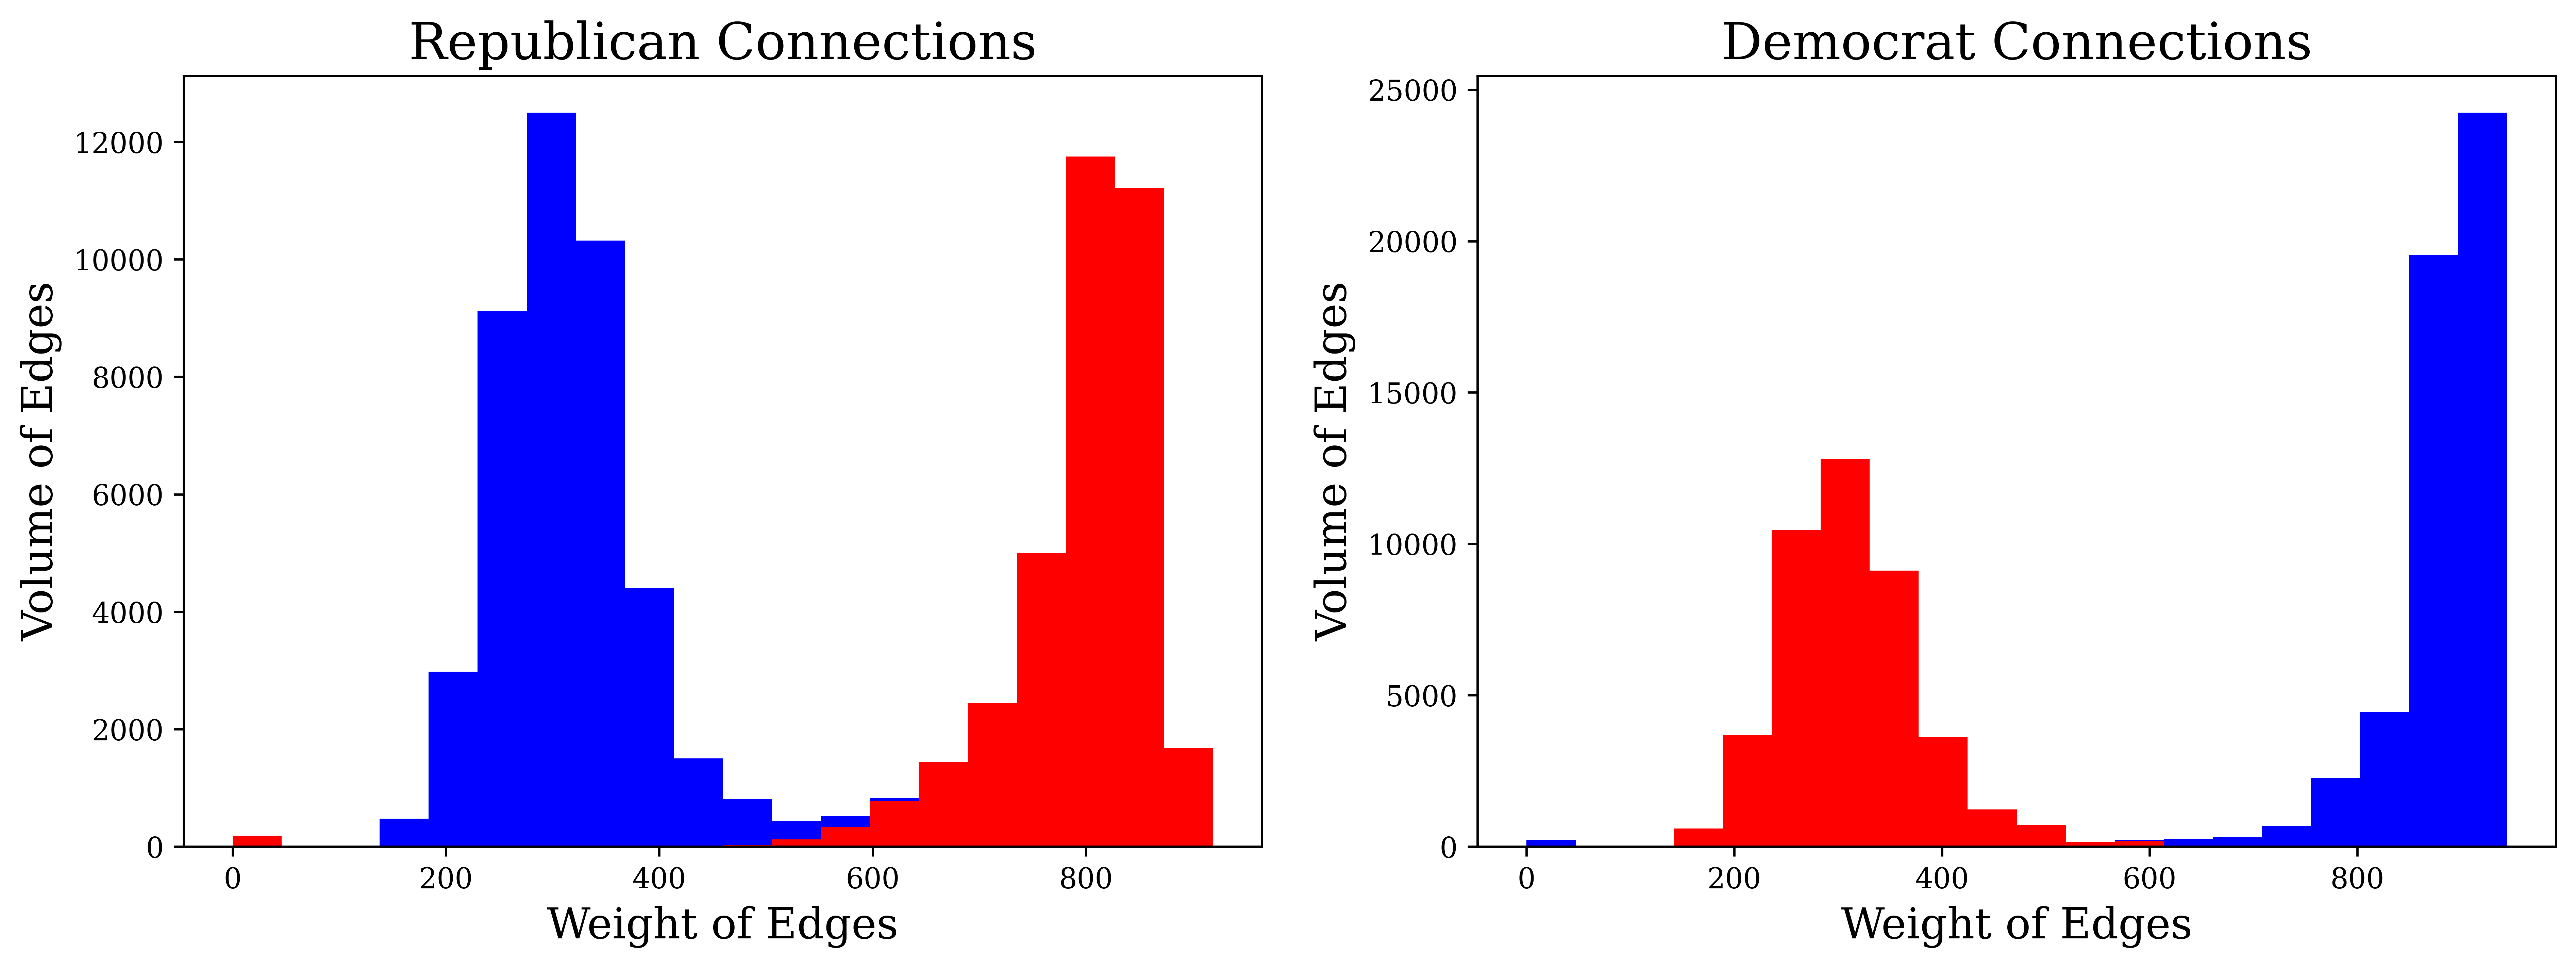

In [35]:
demsID=[data['icpsr'] for node, data in g.nodes(data=True)if data["party_code"]==100]
repsID=[data['icpsr'] for node, data in g.nodes(data=True)if data["party_code"]==200]

#find Republican connection frequencies per party
r2d = dfAdj.loc[repsID,demsID].to_numpy()
r2d = r2d.reshape(r2d.shape[0]*r2d.shape[1],1)
r2r = dfAdj.loc[repsID,repsID].to_numpy()
r2r = r2r.reshape(r2r.shape[0]*r2r.shape[1],1)


#find Democrat connection frequencies per party
d2r = dfAdj.loc[demsID,repsID].to_numpy()
d2r = d2r.reshape(1,d2r.shape[0]*d2r.shape[1])
d2d = dfAdj.loc[demsID,demsID].to_numpy()
d2d = d2d.reshape(1,d2d.shape[0]*d2d.shape[1])


fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.hist([r2r.flatten(),r2d.flatten()], bins=20,stacked=True,color=['red','blue'])
ax1.set_title('Republican Connections', size = 18)
ax1.set_xlabel('Weight of Edges',size = 15)
ax1.set_ylabel('Volume of Edges',size = 15)
ax2.hist([d2r.flatten(),d2d.flatten()], bins=20,stacked=True,color=['red','blue'])
ax2.set_title('Democrat Connections',size = 18)
ax2.set_xlabel('Weight of Edges',size = 15)
ax2.set_ylabel('Volume of Edges',size = 15)
plt.show()

In [17]:
#gTest = g.copy()
#
#edge_weights = nx.get_edge_attributes(gTest,'weight')
#edge_weights
#
#gTest.remove_edges_from((e for e, w in edge_weights.items() if w <450))

In [113]:
#NxPa[((NxPa['ClusterKMeans']==1) & (NxPa['party_code']==200))]

icpsr  congress chamber  state_icpsr  party_code  occupancy  last_means  \
145  21305     116.0   House         71.0       200.0        NaN         NaN   
208  21522     116.0   House         45.0       200.0        NaN         NaN   

            bioname bioguide_id    born  died  nominate_dim1  nominate_dim2  \
145      COOK, Paul     C001094  1943.0   NaN          0.372          0.208   
208  ABRAHAM, Ralph     A000374  1954.0   NaN          0.541          0.257   

     nominate_log_likelihood  nominate_geo_mean_probability  \
145               -106.11394                        0.87064   
208                -62.96669                        0.87964   

     nominate_number_of_votes  nominate_number_of_errors  conditional  \
145                     766.0                       43.0          NaN   
208                     491.0                       29.0          NaN   

     nokken_poole_dim1  nokken_poole_dim2       Age       Pop    PerMin  \
145              0.323              0.370 -1.475001 -0.254213 -0.097684   
208              0.607              0.154 -0.133058 -0.170576  0.674469   

       PerVet     UnEmp  CarCommute    PerBlu  PerOwnOcc  MedIncome  \
145  0.071454  2.685336    0.279505  0.147657  -1.016612  -0.652361   
208 -0.143220  0.613679    0.562312  0.043297  -0.498483  -1.432631   

     BelowPovLine  PerBachelors   Payroll  Accommodation and food services  \
145      0.867803     -1.400738 -0.838755                              1.0   
208      2.287810     -1.319258 -0.602711                              0.0   

     Administrative and support and waste management and remediation services  \
145                                                0.0                          
208                                                0.0                          

     Construction  Educational services  Finance and insurance  \
145           0.0                   0.0                    0.0   
208           0.0                   0.0                    0.0   

     Health care and social assistance  Information  \
145                                0.0          0.0   
208                                1.0          0.0   

     Management of companies and enterprises  Manufacturing  \
145                                      0.0            0.0   
208                                      0.0            0.0   

     Mining, quarrying, and oil and gas extraction  \
145                                            0.0   
208                                            0.0   

     Professional, scientific, and technical services  Retail trade  \
145                                               0.0           0.0   
208                                               0.0           0.0   

     Transportation and warehousing  ClusterBirch  ClusterKMeans  pca_dim_1  \
145                             0.0           0.0            1.0  -2.299033   
208                             0.0           0.0            1.0  -2.431185   

     pca_dim_2  
145   1.756251  
208   1.764770

### Modularity Over Attributes

In [36]:
modMatrix = np.zeros(24)
x = np.arange(-3,3,.25)
for j in DistrictData.iloc[:,0:9].columns:
    #print(j)
    modularity = []
    for i in np.arange(-3,3,.25):
        #cA = [node for node, data in g.nodes(data=True)if data[j]<=i]
        #cB = [node for node, data in g.nodes(data=True)if ((data[j]<i*-1) & (data[j]>i))]
        #cC = [node for node, data in g.nodes(data=True)if data[j]>=i*-1]
        cA = [node for node, data in g.nodes(data=True)if data[j]<=i]
        cB = [node for node, data in g.nodes(data=True)if data[j] >i]

        clusterMod = nx.algorithms.community.modularity(g,communities=[cA,cB])
        modularity.append(clusterMod)
    modMatrix = np.vstack((modMatrix,modularity))
modMatrix = np.delete(modMatrix, 0, 0)

In [37]:
plt.figure()
for i in range(9):
    plt.plot(x, modMatrix[i])
    
leg = DistrictData.iloc[:,0:9].columns

plt.title("Modularity by District Attribute Z-Scores",size=20)
plt.legend(leg,prop={'size': 17})
plt.xlabel("Z-Score",size=17)
plt.ylabel("Modularity")
plt.show()



### Check Cluster Modularity

In [38]:
cKM1 = [node for node, data in g.nodes(data=True)if data["ClusterKMeans"]==0]
cKM2 = [node for node, data in g.nodes(data=True)if data["ClusterKMeans"]==1]
cKM3 = [node for node, data in g.nodes(data=True)if data["ClusterKMeans"]==2]

clusterMod = nx.algorithms.community.modularity(g,communities=[cKM1,cKM2,cKM3])
print("Modularity within KMeans Clusters:",clusterMod)


cB1 = [node for node, data in g.nodes(data=True)if data["ClusterBirch"]==0]
cB2 = [node for node, data in g.nodes(data=True)if data["ClusterBirch"]==1]
cB3 = [node for node, data in g.nodes(data=True)if data["ClusterBirch"]==2]
clusterMod = nx.algorithms.community.modularity(g,communities=[cB1,cB2,cB3])
print("Modularity within Birch Clusters:",clusterMod)

Modularity within KMeans Clusters: 0.057962168093580686
Modularity within Birch Clusters: 0.04591741601438956


In [39]:
mix_mat = nx.attribute_mixing_matrix(g,attribute = 'ClusterKMeans')
print("KMeans:\n",mix_mat)
mix_mat = nx.attribute_mixing_matrix(g,attribute = 'ClusterBirch')
print("Birch:\n",mix_mat)

KMeans:
 [[0.28298702 0.14792503 0.10161807]
 [0.14792503 0.07630522 0.05287818]
 [0.10161807 0.05287818 0.0358652 ]]
Birch:
 [[0.05646936 0.08470403 0.09738083]
 [0.08470403 0.12491706 0.14459577]
 [0.09738083 0.14459577 0.16525231]]


### Subgraph Modularity - KMeans

In [118]:
gC1 = g.copy()

notC1 = cKM2 + cKM3

for i in notC1:
    gC1.remove_node(i)
c1Dems=[node for node, data in gC1.nodes(data=True)if data["party_code"]==100]
c1Reps=[node for node, data in gC1.nodes(data=True)if data["party_code"]==200]

c1Mod = nx.algorithms.community.modularity(gC1,communities=[c1Dems,c1Reps])
print('Democrats:',len(c1Dems))
print('Republicans:',len(c1Reps))
print("Modularity by Party in Cluster 1:",c1Mod)
print(nx.attribute_mixing_matrix(gC1,attribute = 'party_code',mapping=mapping),'\n')

com = nx.community.greedy_modularity_communities(gC1,weight='weight')
modularity_dict = {}
for i,c in enumerate(com):
    for node in c:
        modularity_dict[node]=i
        
nx.set_node_attributes(gC1,modularity_dict,'InfrdMod')
fullMod = nx.algorithms.community.modularity(gC1,communities=[com[0],com[1]])
print("Maximum Modularity:",fullMod)
c1Dems=[node for node, data in gC1.nodes(data=True)if (data["party_code"]==100)&(data['InfrdMod']==1)]
c2Reps=[node for node, data in gC1.nodes(data=True)if (data["party_code"]==200)&(data['InfrdMod']==0)]
print("Inferred Modularity Party Dist 1",len(c1Dems)/len(com[1]))
print("Inferred Modularity Party Dist 2",len(c2Reps)/len(com[0]))

Democrats: 61
Republicans: 160
Modularity by Party in Cluster 1: 0.12535134464984893
[[0.07527766 0.20074044]
 [0.20074044 0.52324146]] 

Maximum Modularity: 0.12553918710482376
Inferred Modularity Party Dist 1 0.9838709677419355
Inferred Modularity Party Dist 2 1.0


In [122]:
gC2 = g.copy()

notC2 = cKM1 + cKM3

for i in notC2:
    gC2.remove_node(i)
c2Dems=[node for node, data in gC2.nodes(data=True)if data["party_code"]==100]
c2Reps=[node for node, data in gC2.nodes(data=True)if data["party_code"]==200]

c2Mod = nx.algorithms.community.modularity(gC2,communities=[c2Dems,c2Reps])
print('Democrats:',len(c2Dems))
print('Republicans:',len(c2Reps))
print("Modularity by Party in Cluster 2:",c2Mod)
print(nx.attribute_mixing_matrix(gC2,attribute = 'party_code',mapping=mapping),'\n')

com = nx.community.greedy_modularity_communities(gC2,weight='weight')
modularity_dict = {}
for i,c in enumerate(com):
    for node in c:
        modularity_dict[node]=i
        
nx.set_node_attributes(gC2,modularity_dict,'InfrdMod')
fullMod = nx.algorithms.community.modularity(gC2,communities=[com[0],com[1]])
print("Maximum Modularity:",fullMod)
c1Dems=[node for node, data in gC2.nodes(data=True)if (data["party_code"]==200)&(data['InfrdMod']==1)]
c2Reps=[node for node, data in gC2.nodes(data=True)if (data["party_code"]==100)&(data['InfrdMod']==0)]
print("Party Dist 1",len(c1Dems)/len(com[1]))
print("Party Dist 2",len(c2Reps)/len(com[0]))

Democrats: 96
Republicans: 19
Modularity by Party in Cluster 2: 0.03745494224836277
[[0.69565217 0.13913043]
 [0.13913043 0.02608696]] 

Maximum Modularity: 0.03785162346589594
Party Dist 1 0.9047619047619048
Party Dist 2 1.0


In [117]:
gC3 = g.copy()

notC3 = cKM1 + cKM2

for i in notC3:
    gC3.remove_node(i)
c3Dems=[node for node, data in gC3.nodes(data=True)if data["party_code"]==100]
c3Reps=[node for node, data in gC3.nodes(data=True)if data["party_code"]==200]

c3Mod = nx.algorithms.community.modularity(gC3,communities=[c3Dems,c3Reps])
print('Democrats:',len(c3Dems))
print('Republicans:',len(c3Reps))
print("Modularity by Party in Cluster 2:",c3Mod)
print(nx.attribute_mixing_matrix(gC3,attribute = 'party_code',mapping=mapping),'\n')


com = nx.community.greedy_modularity_communities(gC3,weight='weight')
modularity_dict = {}
for i,c in enumerate(com):
    for node in c:
        modularity_dict[node]=i
        
nx.set_node_attributes(gC3,modularity_dict,'InfrdMod')
fullMod = nx.algorithms.community.modularity(gC3,communities=[com[0],com[1]])
print("Maximum Modularity:",fullMod)
c1Dems=[node for node, data in gC3.nodes(data=True)if (data["party_code"]==200)&(data['InfrdMod']==1)]
c2Reps=[node for node, data in gC3.nodes(data=True)if (data["party_code"]==100)&(data['InfrdMod']==0)]
print("Party Dist 1",len(c1Dems)/len(com[1]))
print("Party Dist 2",len(c2Reps)/len(com[0]))

Democrats: 71
Republicans: 8
Modularity by Party in Cluster 2: 0.01516822138886308
[[0.80655631 0.09217786]
 [0.09217786 0.00908796]] 

Maximum Modularity: 0.01516822138886308
Party Dist 1 1.0
Party Dist 2 1.0


### Subgraph Modularity - Birch

In [114]:
gC1 = g.copy()

notC1 = cB2 + cB3

for i in notC1:
    gC1.remove_node(i)
c1Dems=[node for node, data in gC1.nodes(data=True)if data["party_code"]==100]
c1Reps=[node for node, data in gC1.nodes(data=True)if data["party_code"]==200]

c1Mod = nx.algorithms.community.modularity(gC1,communities=[c1Dems,c1Reps])
print('Democrats:',len(c1Dems))
print('Republicans:',len(c1Reps))
print("Modularity by Party in Cluster 1:",c1Mod)
print(nx.attribute_mixing_matrix(gC1,attribute = 'party_code',mapping=mapping),'\n')


com = nx.community.greedy_modularity_communities(gC1,weight='weight')
modularity_dict = {}
for i,c in enumerate(com):
    for node in c:
        modularity_dict[node]=i
        
nx.set_node_attributes(gC1,modularity_dict,'InfrdMod')
fullMod = nx.algorithms.community.modularity(gC1,communities=[com[0],com[1]])
print("Maximum Modularity:",fullMod)
c1Dems=[node for node, data in gC1.nodes(data=True)if (data["party_code"]==200)&(data['InfrdMod']==1)]
c2Reps=[node for node, data in gC1.nodes(data=True)if (data["party_code"]==100)&(data['InfrdMod']==0)]
print("Party Dist 1",len(c1Dems)/len(com[1]))
print("Party Dist 2",len(c2Reps)/len(com[0]))

Democrats: 78
Republicans: 21
Modularity by Party in Cluster 1: 0.07070178290603678
[[0.61904762 0.16883117]
 [0.16883117 0.04329004]] 

Maximum Modularity: 0.07070178290603678
Party Dist 1 1.0
Party Dist 2 1.0


In [112]:
gC2 = g.copy()

notC2 = cB1 + cB3

for i in notC2:
    gC2.remove_node(i)
c2Dems=[node for node, data in gC2.nodes(data=True)if data["party_code"]==100]
c2Reps=[node for node, data in gC2.nodes(data=True)if data["party_code"]==200]

c2Mod = nx.algorithms.community.modularity(gC2,communities=[c2Dems,c2Reps])
print('Democrats:',len(c2Dems))
print('Republicans:',len(c2Reps))
print("Modularity by Party in Cluster 2:",c2Mod)
print(nx.attribute_mixing_matrix(gC2,attribute = 'party_code',mapping=mapping),'\n')

com = nx.community.greedy_modularity_communities(gC2,weight='weight')
modularity_dict = {}
for i,c in enumerate(com):
    for node in c:
        modularity_dict[node]=i
        
nx.set_node_attributes(gC2,modularity_dict,'InfrdMod')
fullMod = nx.algorithms.community.modularity(gC2,communities=[com[0],com[1]])
print("Maximum Modularity:",fullMod)
c1Dems=[node for node, data in gC2.nodes(data=True)if (data["party_code"]==200)&(data['InfrdMod']==1)]
c2Reps=[node for node, data in gC2.nodes(data=True)if (data["party_code"]==100)&(data['InfrdMod']==0)]
print("Party Dist 1",len(c1Dems)/len(com[1]))
print("Party Dist 2",len(c2Reps)/len(com[0]))

Democrats: 111
Republicans: 36
Modularity by Party in Cluster 2: 0.08595793956644436
[[0.5689125  0.18618954]
 [0.18618954 0.05870841]] 

Maximum Modularity: 0.08595793956644436
Party Dist 1 1.0
Party Dist 2 1.0


In [116]:
gC3 = g.copy()

notC3 = cB1 + cB2

for i in notC3:
    gC3.remove_node(i)
c3Dems=[node for node, data in gC3.nodes(data=True)if data["party_code"]==100]
c3Reps=[node for node, data in gC3.nodes(data=True)if data["party_code"]==200]

c3Mod = nx.algorithms.community.modularity(gC3,communities=[c3Dems,c3Reps])
print('Democrats:',len(c3Dems))
print('Republicans:',len(c3Reps))
print("Modularity by Party in Cluster 2:",c3Mod)
print(nx.attribute_mixing_matrix(gC3,attribute = 'party_code',mapping=mapping),'\n')


com = nx.community.greedy_modularity_communities(gC3,weight='weight')
modularity_dict = {}
for i,c in enumerate(com):
    for node in c:
        modularity_dict[node]=i
        
nx.set_node_attributes(gC3,modularity_dict,'InfrdMod')
fullMod = nx.algorithms.community.modularity(gC3,communities=[com[0],com[1]])
print("Maximum Modularity:",fullMod)
c1Dems=[node for node, data in gC3.nodes(data=True)if (data["party_code"]==100)&(data['InfrdMod']==1)]
c2Reps=[node for node, data in gC3.nodes(data=True)if (data["party_code"]==200)&(data['InfrdMod']==0)]
print("Party Dist 1",len(c1Dems)/len(com[1]))
print("Party Dist 2",len(c2Reps)/len(com[0]))

Democrats: 39
Republicans: 130
Modularity by Party in Cluster 2: 0.08905467490516736
[[0.0521978  0.17857143]
 [0.17857143 0.59065934]] 

Maximum Modularity: 0.08981391348198885
Party Dist 1 0.9285714285714286
Party Dist 2 1.0


In [164]:
cKM3D = [node for node, data in g.nodes(data=True)if (data["ClusterKMeans"] in [1,2]) & (data["party_code"]==100)]
cKM1R = [node for node, data in g.nodes(data=True)if (data["ClusterKMeans"]==0) & (data["party_code"]==200)]
full = g.nodes


KMMaxMod = g.copy()

KMMax = [node for node in full if node not in cKM3D and node not in cKM1R]

for i in KMMax:
    KMMaxMod.remove_node(i)

clusterMod = nx.algorithms.community.modularity(KMMaxMod,communities=nx.community.greedy_modularity_communities(KMMaxMod,weight='weight'))
print("Modularity between Cluster Extremes:",clusterMod)

Modularity between Cluster Extremes: 0.23090280471465038
